# Big Data Analysis Report on "Weapons and Drugs"

<pre>
In this report, we will try to analyze 3 claims made at <b>“Ross Kemp and the Armed Police” broadcast 6th September 2018 by ITV</b>

The claims made at the show were:
1. Violent Crime is increasing
2. There are more firearms incidents per head in Birmingham than anywhere else in the UK
3. Crimes involving firearms are closely associated with drugs offences

We will try to analyze each of the claim on the basis of data, tools used for the analyses will be Spark Core, Spark ML, Matplotlib etc.
</pre>

----------------------------------------------------------------------------------------------------------

<pre>
Before we start any analysis, lets read all the required libraries we will be needing to do the analysis.
</pre>

In [1]:
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as fn
from pyspark.sql.types import *
from pyspark.sql import Window

from matplotlib import pyplot as plt

from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorAssembler

<pre>
Spark Session is the entry point to access all the APIs of Spark Core. Let us initialize spark session variable in the next cell by giving all the required parameters
</pre>

In [2]:
spark = SparkSession \
                    .builder \
                    .appName("Weapons And Drugs") \
                    .getOrCreate()

In [3]:
spark

<pre>
So, now as the SparkSession variable have been initialized, lets now proceed to analyze the claims made at the show.
</pre>

## Claim1: Violent Crime is increasing

<pre>
To prove this claim, we will need UK crime dataset which is available at the UK Crime Department official website<sup>[1]</sup>. 

    The dataset contains crime data in UK with coordinated and the Region Code (known as LSOA) which helps in understanding the crime trends in each of the regions. Dataset is of 1.7 GB size in compressed form and have data with more than 15 years and about 45 Million records. So, overall the dataset is a huge one with all the necessary details required to analyze our claim 1.
    
So without further ado, lets proceed and read our dataset.
</pre>

In [4]:
# We will automatically inferSchema and header from the dataset
uk_crimes_df = spark.read.format("csv") \
                         .option("delimiter", ',') \
                         .option("header", True) \
                         .option("inferSchema", True) \
                         .load("/home/hduser/work/nikhil/dataset/all_crimes18_hdr.txt.gz")

# As the column names are little messy, we will rename the columns and select only the required columns from the 
# dataset for further analysis
uk_crimes_df = uk_crimes_df.withColumnRenamed("Crime ID", "crime_id") \
                           .withColumnRenamed("Month", "month") \
                           .withColumnRenamed("LSOA code", "lsoa_code") \
                           .withColumnRenamed("LSOA name", "lsoa_name") \
                           .withColumnRenamed("Crime type", "crime_type") \
                           .select("crime_id", "month", "lsoa_code", "lsoa_name", "crime_type")

# Lets check out some of the data
uk_crimes_df.show(10, False)

+--------+-------+---------+---------------------------------+---------------------+
|crime_id|month  |lsoa_code|lsoa_name                        |crime_type           |
+--------+-------+---------+---------------------------------+---------------------+
|null    |2010-12|E01017662|Aylesbury Vale 015C              |Other crime          |
|null    |2010-12|E01014399|Bath and North East Somerset 001A|Anti-social behaviour|
|null    |2010-12|E01014399|Bath and North East Somerset 001A|Anti-social behaviour|
|null    |2010-12|E01014399|Bath and North East Somerset 001A|Anti-social behaviour|
|null    |2010-12|E01014399|Bath and North East Somerset 001A|Anti-social behaviour|
|null    |2010-12|E01014399|Bath and North East Somerset 001A|Anti-social behaviour|
|null    |2010-12|E01014399|Bath and North East Somerset 001A|Burglary             |
|null    |2010-12|E01014399|Bath and North East Somerset 001A|Burglary             |
|null    |2010-12|E01014399|Bath and North East Somerset 001A|Oth

<pre>
As we can see, some of the crime_id data are null, so lets filter out such data so we have better veracity of data
</pre>

In [5]:
uk_crimes_df = uk_crimes_df.where(fn.col("crime_id").isNotNull())

# Lets check the count of the final dataset
print("Count: ",uk_crimes_df.count())

uk_crimes_df.show(10, False)

Count:  27219493
+----------------------------------------------------------------+-------+---------+-------------+-------------+
|crime_id                                                        |month  |lsoa_code|lsoa_name    |crime_type   |
+----------------------------------------------------------------+-------+---------+-------------+-------------+
|6dae6f1d627f943b964aa6811c7d72a0d84b04c3e78ff2771c5e4c4be1cf2ba6|2010-12|E01027979|Ashfield 001A|Burglary     |
|f41943f3f036bd20213416925de78618e42fd6f000f2e8fc3c81d5cde7bc1127|2010-12|E01027979|Ashfield 001A|Other crime  |
|d99b5a5717cd1a93a43a4dc135e8f8936baf792664cabeb59eae503c3aa599fc|2010-12|E01027979|Ashfield 001A|Other crime  |
|e830903bf868402f8523cfb016cd8707cd2cdf39925f008fc67f691060fa755f|2010-12|E01027979|Ashfield 001A|Other crime  |
|ed992f91018253c6c7eaa116f2f4de7fae7b75a342a005e6dd13b11bd9575e48|2010-12|E01027980|Ashfield 001B|Burglary     |
|abc7e8785381dec2a7a65da2ffe91026af7f133d110efdabe08b48c903bc6fd2|2010-12|E0102

<pre>
To check if the violent crimes are increasing, we will firstly filter out the crimes related to violence and then aggregate the data at month level and find the count of violent crimes for each month to understand whether the violent crime is increasing or not.
</pre>

In [23]:
# Lets check the types of crimes as per the dataset

uk_crimes_df.select("crime_type").distinct().show(50, False)

+----------------------------+
|crime_type                  |
+----------------------------+
|Bicycle theft               |
|Public order                |
|Drugs                       |
|Public disorder and weapons |
|Other crime                 |
|Robbery                     |
|Criminal damage and arson   |
|Theft from the person       |
|Shoplifting                 |
|Burglary                    |
|Violent crime               |
|Other theft                 |
|Possession of weapons       |
|Violence and sexual offences|
|Vehicle crime               |
+----------------------------+



In [22]:
# Lets check how many months of data we have in our dataset

uk_crimes_df.select("month").distinct().count()

92

In [24]:
# Getting data related to violent crimes

violent_crimes_list = ['Public disorder and weapons', 'Criminal damage and arson', 'Violent crime',
                       'Possession of weapons', 'Violence and sexual offences']

uk_violent_crimes_df = uk_crimes_df.where(fn.col("crime_type").isin(violent_crimes_list))

<pre>
Now, as we have the data related to violent crimes, we will group the data on monthly basis and visualize the data to check whether the claim 'Violent Crimes are increasing' is true or not
</pre>

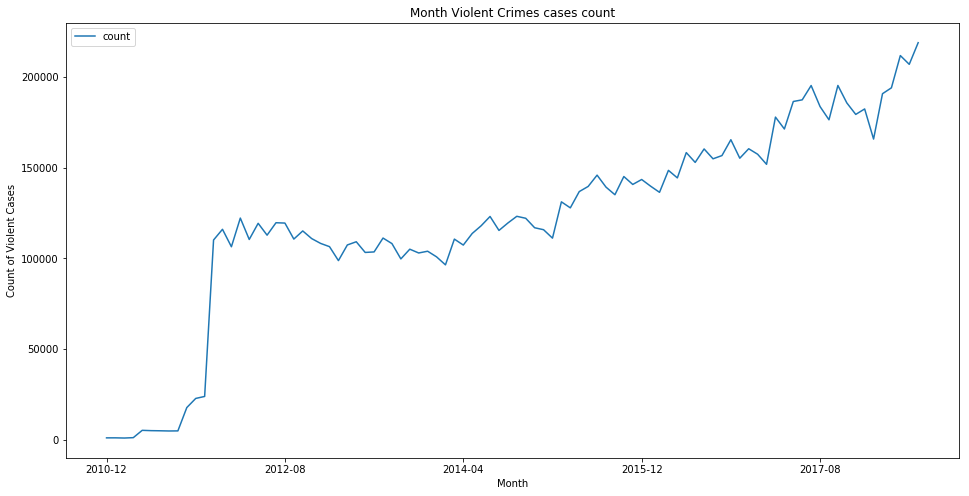

In [26]:
grouped_df = uk_violent_crimes_df.groupBy("month").count()
grouped_pd = grouped_df.orderBy("month").toPandas()


# Visualizing the data using Line Graph
grouped_pd.plot(x="month", y="count", kind="line", figsize=(16, 8))
plt.title("Month Violent Crimes cases count")
plt.xlabel("Month")
plt.ylabel("Count of Violent Cases")
plt.show()

<pre>
So as the graph is showing, the number of cases are increasing regularly. So the claim made holds true, but for further proof, lets us find the average percentage increase in number of cases per each month.
</pre>

In [36]:
# To calculate average percentage, firstly lets get the change in count of cases per each month

window = Window.orderBy("month")

grouped_df2 = grouped_df.withColumn("prev_month_count", fn.lag(fn.col("count"), 1).over(window))

In [37]:
grouped_df2.where(fn.col("prev_month_count").isNotNull())

+-------+------+----------------+
|  month| count|prev_month_count|
+-------+------+----------------+
|2010-12|  1067|            null|
|2011-01|  1080|            1067|
|2011-02|   975|            1080|
|2011-03|  1185|             975|
|2011-04|  5218|            1185|
|2011-05|  5044|            5218|
|2011-06|  4972|            5044|
|2011-07|  4863|            4972|
|2011-08|  4909|            4863|
|2011-09| 17765|            4909|
|2011-10| 22800|           17765|
|2011-11| 23894|           22800|
|2011-12|110119|           23894|
|2012-01|116016|          110119|
|2012-02|106394|          116016|
|2012-03|122203|          106394|
|2012-04|110413|          122203|
|2012-05|119312|          110413|
|2012-06|112778|          119312|
|2012-07|119632|          112778|
+-------+------+----------------+
only showing top 20 rows



In [39]:
# Now, we will calculate the percentage change in count for each month
grouped_df3 = grouped_df2.where(fn.col("prev_month_count").isNotNull())\
                         .withColumn("percentage_change", 
                             fn.round(100*(( fn.col("count")-fn.col("prev_month_count"))/fn.col("count")), 2))

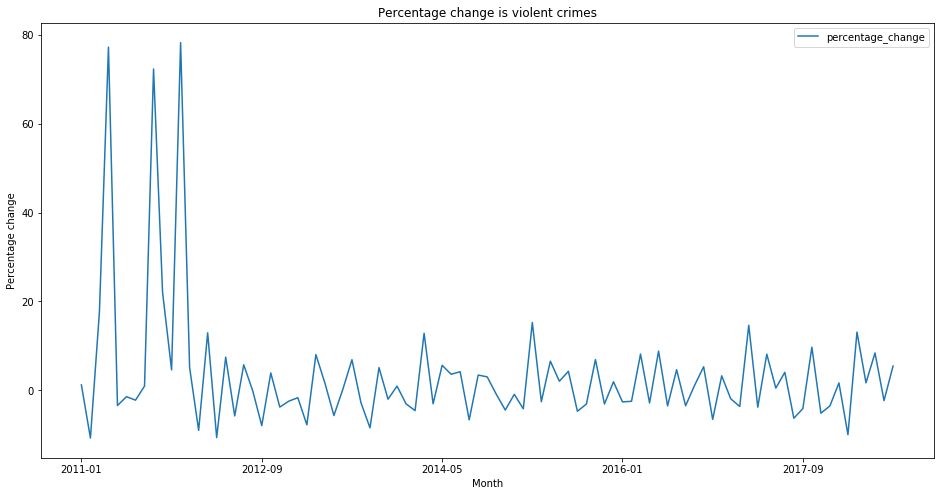

In [40]:
grouped_pd2 = grouped_df3.orderBy("month").toPandas()

# Visualizing the data using Line Graph
grouped_pd2.plot(x="month", y="percentage_change", kind="line", figsize=(16, 8))
plt.title("Percentage change is violent crimes")
plt.xlabel("Month")
plt.ylabel("Percentage change")
plt.show()

In [42]:
# Finding average percentage change in number of violent cases 

grouped_df3.agg(fn.avg("percentage_change").alias("avg_percentage_change")).show()

+---------------------+
|avg_percentage_change|
+---------------------+
|     3.40967032967033|
+---------------------+



<pre>
So with the above analysis showing that the average percentage increase in violent cases is positive 
(~3.4%), we can conclude that the claim that <i>"Violent Crimes are increasing"</i> holds true.

With this claim analyzed, let us move on to analyzing our second claim...
</pre>

## Claim2: 
## There are more firearms incidents per head in Birmingham than anywhere else in the UK

<pre>
So, we will have to compare the number of firearms incident per head for each of the city in UK. But, our current dataset is not enough for this analysis, so we will need a dataset which contains all such details.

UK postal codes dataset<sup>[2]</sup> contains all such information, moreover it contains LSOA region details which is present in our crimes dataset so we can merge both the datasets whenever or wherever necessary. Postal codes dataset is of around 650mb is size (uncompressed) and contains almost 2.5 Million records.

So, lets move forward and read the dataset and start our analysis for Claim-2.
</pre>

In [6]:
# Dataset do not have headers, so we will have to provide static schema to it
uk_postcode_schema = StructType([
                                StructField("postcode", StringType(), nullable=True),
                                StructField("inUse", StringType(), nullable=True),
                                StructField("latitude", StringType(), nullable=True),
                                StructField("longitude", StringType(), nullable=True),
                                StructField("easting", StringType(), nullable=True),
                                StructField("northing", StringType(), nullable=True),
                                StructField("gridRef", StringType(), nullable=True),
                                StructField("county", StringType(), nullable=True),
                                StructField("district", StringType(), nullable=True),
                                StructField("ward", StringType(), nullable=True),
                                StructField("districtCode", StringType(), nullable=True),
                                StructField("wardCode", StringType(), nullable=True),
                                StructField("country", StringType(), nullable=True),
                                StructField("countyCode", StringType(), nullable=True),
                                StructField("constituency", StringType(), nullable=True),
                                StructField("introduced", StringType(), nullable=True),
                                StructField("terminated", StringType(), nullable=True),
                                StructField("parish", StringType(), nullable=True),
                                StructField("nationalPark", StringType(), nullable=True),
                                StructField("population", IntegerType(), nullable=True),
                                StructField("households", StringType(), nullable=True),
                                StructField("builtUpArea", StringType(), nullable=True),
                                StructField("builtupsubdivision", StringType(), nullable=True),
                                StructField("lsoa_name", StringType(), nullable=True),
                                StructField("rural/urban", StringType(), nullable=True),
                                StructField("region", StringType(), nullable=True),
                                StructField("altitude", StringType(), nullable=True)
                            ])

# Reading the dataset
uk_postcode_df = spark.read.format("csv") \
                            .option("delimiter", ',') \
                            .option("header", False) \
                            .schema(uk_postcode_schema) \
                            .load("/home/hduser/work/nikhil/dataset/postcodes.gz")

# Selecting only needful columns for further analysis
uk_postcode_df = uk_postcode_df.select("district", "lsoa_name", "population")

In [7]:
# Displaying the dataset

uk_postcode_df.show(10, False)

+-------------+-----------------------------------------+----------+
|district     |lsoa_name                                |population|
+-------------+-----------------------------------------+----------+
|Aberdeen City|Cults, Bieldside and Milltimber West - 02|null      |
|Aberdeen City|Cults, Bieldside and Milltimber West - 02|null      |
|Aberdeen City|Cults, Bieldside and Milltimber West - 02|null      |
|Aberdeenshire|Dunecht, Durris and Drumoak - 01         |null      |
|Aberdeen City|Culter - 06                              |null      |
|Aberdeen City|Culter - 01                              |null      |
|Aberdeen City|Cults, Bieldside and Milltimber West - 02|null      |
|Aberdeen City|Culter - 06                              |null      |
|Aberdeen City|Cults, Bieldside and Milltimber West - 02|null      |
|Aberdeen City|Cults, Bieldside and Milltimber West - 02|null      |
+-------------+-----------------------------------------+----------+
only showing top 10 rows



<pre>
As we can see, at some places population is coming as null, so removing such data before we proceed for grouping the dataset
</pre>

In [8]:
# Filtering the dataset
uk_postcode_df = uk_postcode_df.filter("population is not null")

# Checking the count of the resulting dataset
uk_postcode_df.count()

1490292

<pre>
Now, we will merge both the datasets to form the resultant dataset
</pre>

In [9]:
# Joining the dataset
df_joined = uk_crimes_df.join(uk_postcode_df, "lsoa_name", "inner")

# Selecting only the required columns
df_joined = df_joined.select("district", "month", "population")

In [17]:
df_joined.show()

+--------------+-------+----------+
|      district|  month|population|
+--------------+-------+----------+
|Aylesbury Vale|2010-12|       149|
|Aylesbury Vale|2010-12|       194|
|Aylesbury Vale|2010-12|        12|
|Aylesbury Vale|2010-12|        46|
|Aylesbury Vale|2010-12|        72|
|Aylesbury Vale|2010-12|        86|
|Aylesbury Vale|2010-12|        18|
|Aylesbury Vale|2010-12|        87|
|Aylesbury Vale|2010-12|        51|
|Aylesbury Vale|2010-12|         5|
|Aylesbury Vale|2010-12|        51|
|Aylesbury Vale|2010-12|         9|
|Aylesbury Vale|2010-12|        13|
|Aylesbury Vale|2010-12|        95|
|Aylesbury Vale|2010-12|        21|
|Aylesbury Vale|2010-12|        95|
|Aylesbury Vale|2010-12|        20|
|Aylesbury Vale|2010-12|        55|
|Aylesbury Vale|2010-12|        39|
|Aylesbury Vale|2010-12|        44|
+--------------+-------+----------+
only showing top 20 rows



<pre>
Now, as our data have been merged we will filter out crimes data only related to firearms as we have to perform analysis based on that.
</pre>

In [18]:
# Filtering the dataset

firearms_crimes_list = ["Public disorder and weapons", "Possession of weapons"]

df_filter = df_joined.where(fn.col("crime_type").isin(firearms_crimes_list))

In [21]:
df_filter.show(10, False)

+----------------------------+-------+----------+
|district                    |month  |population|
+----------------------------+-------+----------+
|Bath and North East Somerset|2011-09|77        |
|Bath and North East Somerset|2011-09|62        |
|Bath and North East Somerset|2011-09|18        |
|Bath and North East Somerset|2011-09|18        |
|Bath and North East Somerset|2011-09|6         |
|Bath and North East Somerset|2011-09|17        |
|Bath and North East Somerset|2011-09|36        |
|Bath and North East Somerset|2011-09|33        |
|Bath and North East Somerset|2011-09|77        |
|Bath and North East Somerset|2011-09|45        |
+----------------------------+-------+----------+
only showing top 10 rows



<pre>
Now, we have the dataset ready with only the relevant data. We will group the dataset by each district and find the total population in each district and the count of firearms cases
</pre>

In [22]:
df_grouped = df_filter.groupBy("district")\
                      .agg(fn.sum("population").alias("tot_population"),
                           fn.count("*").alias("tot_firearms_cases"))

<pre>
We will now calculate number of firearms cases per head by dividing the total number of firearms cases in each district by its total population. This will give us clear idea that which district is having highest number of firearms cases per head.
</pre>

In [25]:
df_cases_per_head = df_grouped.withColumn("firearms_cases_per_head",
                                         fn.round(fn.col("tot_firearms_cases")/fn.col("tot_population"), 3))

<pre>
So now we have the data of number of firearms cases per head for each of the district in UK, lets check out the top 10 districts with most number of firearms cases per head.
</pre>

In [26]:
df_cases_per_head.orderBy("firearms_cases_per_head", ascending=False).show(10, False)

+--------------+--------------+------------------+-----------------------+
|district      |tot_population|tot_firearms_cases|firearms_cases_per_head|
+--------------+--------------+------------------+-----------------------+
|City of London|836243        |88520             |0.106                  |
|Westminster   |9737223       |585494            |0.06                   |
|West Somerset |37721         |1940              |0.051                  |
|Eden          |295946        |12641             |0.043                  |
|Copeland      |555800        |22231             |0.04                   |
|Craven        |284252        |11422             |0.04                   |
|South Hams    |446926        |18052             |0.04                   |
|East Devon    |949012        |37887             |0.04                   |
|Powys         |1210522       |48003             |0.04                   |
|Chichester    |841535        |32428             |0.039                  |
+--------------+---------

In [27]:
df_cases_per_head.where("district == 'Birmingham'").show()

+----------+--------------+------------------+-----------------------+
|  district|tot_population|tot_firearms_cases|firearms_cases_per_head|
+----------+--------------+------------------+-----------------------+
|Birmingham|      15902149|            284509|                  0.018|
+----------+--------------+------------------+-----------------------+



<pre>
So, as per the analysis we did the district with most number of firearms cases per head is 'City Of London' with approximately <i>0.106 firearms cases per head</i> and not Birmingham which has only <i>0.018 firearms cases per head</i> which is almost 6-7 times lesser than the frontrunner district. This means that the claim that <b>There are more firearms incidents per head in Birmingham than anywhere else in the UK</b> is incorrect.

So, with the second claim analyzed lets proceed to analyzing the final claim which states that <i>"Crimes involving firearms are closely associated with drugs offences"</i>
</pre>

## Claim-3: Crimes involving firearms are closely associated with drugs offences

<pre>
So, in this claim we have to analyze the association between the two crimes happening. As we cannot directly find the association between the two crimes, we will use Pearson's ChiSquareTest to find statistical significance of number of cases involving firearms on the number of cases involving drugs offences. We will do this analysis at district level and at region/LSOA level and compare the results to get full understanding of the scenario.

We will join the dataframes to get postal data and crimes data in one dataframe and the will create two different dataframes, one for firearms related cases and one for drugs related cases.
</pre>

In [9]:
# Merging the datasets
df_merged = uk_crimes_df.join(uk_postcode_df, "lsoa_name", "inner")

df_firearms = df_merged.where(fn.col("crime_type").isin(["Public disorder and weapons", "Possession of weapons"]))
df_drugs = df_merged.where(fn.col("crime_type").isin(["Drugs"]))

<pre>
Now, we can group the dataset at LSOA or region level and count the number of cases of each type. Then, we can merge both the datasets and perform the Hypothesis testing to check the significance of one column on another.
</pre>

In [10]:
# Aggregating the datasets at region level
df_firearms_lsoa = df_firearms.groupBy("lsoa_code").agg(fn.count("*").alias("firearms_count_per_lsoa"))
df_drugs_lsoa = df_drugs.groupBy("lsoa_code").agg(fn.count("*").alias("drugs_count_per_lsoa"))

# Now merging the dataset
df_lsoa_merged = df_firearms_lsoa.join(df_drugs_lsoa, "lsoa_code", "inner")

<pre>
So, now as we have the final merged dataset ready, we will perform Pearson' ChiSquareTest for Statistical Significance using Spark ML's library
</pre>

In [16]:
# As column vector is needed, creating vector of the column
assembler = VectorAssembler(inputCols=["drugs_count_per_lsoa"], 
                            outputCol="vector", 
                            handleInvalid='skip')

df_vector = assembler.transform(df_lsoa_merged)

In [17]:
# Running the algorithm
hypothesis_test = ChiSquareTest.test(df_vector, "vector", "firearms_count_per_lsoa").head()

In [18]:
# Checking out the results    

print("pValues: " + str(hypothesis_test.pValues))
print("degreesOfFreedom: " + str(hypothesis_test.degreesOfFreedom))
print("statistics: " + str(hypothesis_test.statistics))

pValues: [0.0]
degreesOfFreedom: [4970025]
statistics: [27308596.24978999]


<pre>
As the p-Value is less, our Hypothesis stands true.

For further proof, we will do the same analysis again but this time at district level and check if the claim still holds true.
</pre>

In [20]:
# Aggregating the datasets at district level
df_firearms_district = df_firearms.groupBy("district").agg(fn.count("*").alias("firearms_count_per_district"))
df_drugs_district = df_drugs.groupBy("district").agg(fn.count("*").alias("drugs_count_per_district"))

# Joining both the datasets
df_district_merged = df_firearms_district.join(df_drugs_district, "district", "inner")

In [21]:
# As column vector is needed, creating vector of the column
assembler = VectorAssembler(inputCols=["drugs_count_per_district"], 
                            outputCol="vector", 
                            handleInvalid='skip')

df_vector = assembler.transform(df_district_merged)

In [22]:
# Running the algorithm
hypothesis_test = ChiSquareTest.test(df_vector, "vector", "firearms_count_per_district").head()

# Checking out the results    
print("pValues: " + str(hypothesis_test.pValues))
print("degreesOfFreedom: " + str(hypothesis_test.degreesOfFreedom))
print("statistics: " + str(hypothesis_test.statistics))

pValues: [0.23985465722940025]
degreesOfFreedom: [120062]
statistics: [120408.00000010489]


<pre>
As the value at district level results also signifies the same results as of region/LSOA level, our previous analysis holds true.

So, as per our analysis, the third claim made at the show which is <i>"Crimes involving firearms are closely associated with drugs offences"</i> holds true.

Now, with all the claims analyzed, we will check some advantages and disadvantages of the methods and tools we have used and finally References for the document are attached at the end.
</pre>

----------------

<b>Advantages:</b>
- Apache Spark can be used on multi cluster as well, so using that allows us to scale and run our code on larger datasets.
- ChiSquare Test helps use prove the Hypothesis so using that helps us in proving the 3rd claim.
- ChiSquare Test is much more easy to compute than other statistics.
- Using matplotlib for visualization is easier in Jupyter Notebook rather than using other libraries.
- ChiSquare test can be used to check association between the two variable<sup>[10]</sup>


<b>Disadvantages:</b>
- Number of observations for ChiSquareTest should be more for better results.
- Using Matplotlib for visualization prohibits us from visualizing larger datasets as it can only visualize data stored in pandas.
- Spark when use on single cluster is not that much beneficial as we are not using its full capabilities.

### References:
<pre>
[1] UK Crime Department website: https://data.police.uk/data/
[2] Postal Codes Dataset: https://s3.amazonaws.com/kf7032-20.northumbria.ac.uk/postcodes.gz
[3] Spark Core: https://spark.apache.org/docs/latest/
[4] Pearson's ChiSquareTest: https://dzone.com/articles/hypothesis-testing-with-spark-20
[5] Spark Hypothesis Test: https://spark.apache.org/docs/latest/ml-statistics.html#hypothesis-testing
[6] p-Value Significance: https://www.statsdirect.com/help/basics/p_values.htm#:~:text=The%20P%20value%2C%20or%20calculated,the%20hypothesis%20is%20being%20tested. 
[7] Hypothesis Testing & p-Value: https://towardsdatascience.com/hypothesis-testing-p-value-13b55f4b32d9
[8] Matplotlib: https://matplotlib.org/
[9] Chi-square Strength/Weakness: https://passel2.unl.edu/view/lesson/9beaa382bf7e/14
[10] ChiSquare Test Advantages/Disadvantages: https://getrevising.co.uk/grids/chi_squared
</pre>